In [57]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta
import numpy as np
from datetime import timedelta


########################################################################
# 策略继承CtaTemplate
class VWAP_CDL_Strategy(CtaTemplate):
    """反转策略Demo"""
    className = 'VWAP_CDL_Strategy'
    author = 'Boyang Lyu'
    
    # 策略参数
    lot = 1             # 设置手数
    holdHour = 20    # 最长持有时间
    VWAPPeriod = 70
    trailingPct = 0.04
    fastPeriod = 21
    slowPeriod = 53
    
    # 策略变量
    transactionPrice = {} # 记录成交价格
    intraTradeLowDict = {}
    intraTradeHighDict = {}
    maTrend = {}
    
    # 参数列表
    paramList = ['lot',
                 'holdHour',
                 'VWAPPeriod',
                 'trailingPct = 0.04',
                 'fastPeriod',
                 'slowPeriod']    
    
    # 变量列表
    varList = ['transactionPrice',
               'intraTradeLowDict',
               'intraTradeHighDict',
               'maTrend']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把ReversalStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
      
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.intraTradeHighDict = {s:0 for s in self.symbolList}
        self.intraTradeLowDict = {s:999999 for s in self.symbolList}
        self.maTrend = {s:0 for s in self.symbolList}
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass

    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        symbol = bar.vtSymbol
        #价格百分比止盈止损
        # 洗价器（止盈止损）
        if self.posDict[symbol+'_LONG'] == 0 and self.posDict[symbol+'_SHORT'] == 0:
            self.intraTradeHighDict[symbol] = 0
            self.intraTradeLowDict[symbol] = 999999

        # 持有多头仓位
        elif self.posDict[symbol+'_LONG'] >0:
            self.intraTradeHighDict[symbol] = max(self.intraTradeHighDict[symbol], bar.high)
            self.longStop = self.intraTradeHighDict[symbol]*(1-self.trailingPct)
            if bar.close<=self.longStop:
                self.cancelAll()
                self.sell(symbol, bar.close*0.9, self.posDict[symbol+'_LONG'])

#         # 持有空头仓位
        elif self.posDict[symbol+'_SHORT'] >0:
            self.intraTradeLowDict[symbol] = min(self.intraTradeLowDict[symbol], bar.low)
            self.shortStop = self.intraTradeLowDict[symbol]*(1+self.trailingPct)
            if bar.close>=self.shortStop:
                self.cancelAll()
                self.cover(symbol, bar.close*1.1, self.posDict[symbol+'_SHORT'])
        self.putEvent()

    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60分钟Bar推送"""
        symbol = bar.vtSymbol
        am60 = self.getArrayManager(symbol, "60m") # 获取历史数组
        
        if not am60.inited:
            return
        # 计算EMA判断趋势-------------------------------------------------
        fastEMa = ta.EMA(am60.close, self.fastPeriod)
        slowEMa = ta.EMA(am60.close, self.slowPeriod)
        
        if (fastEMa[-1] > slowEMa[-1]) and (fastEMa[-2] < slowEMa[-2]):
            self.maTrend[symbol] = 1
        elif (fastEMa[-1] < slowEMa[-1]) and (fastEMa[-2] > slowEMa[-2]):
            self.maTrend[symbol] = -1
            
        # 计算策略需要的信号-------------------------------------------------
        engulfing = ta.CDLENGULFING(am60.open.reshape(-1), am60.high.reshape(-1), am60.low.reshape(-1), am60.close.reshape(-1))
        VWAP = ta.SUM(am60.close.reshape(-1) * am60.volume.reshape(-1), self.VWAPPeriod) / ta.SUM(am60.volume.reshape(-1), self.VWAPPeriod)
        
        breakUpVwap = (am60.close[-1] > VWAP[-2]) and (am60.close[-2] <= VWAP[-2])
        breakDnVwap = (am60.close[-1] < VWAP[-2]) and (am60.close[-2] >= VWAP[-2])
        # 构建进出场逻辑-------------------------------------------------
        # 如果看涨吞没模式出现时手头没有多头持仓
        if (self.maTrend[symbol] == 1) and (breakUpVwap or engulfing[-1] == 100) and (self.posDict[symbol+'_LONG'] == 0):
            # 如果没有空头持仓，则直接做多
            if  self.posDict[symbol+'_SHORT']==0:
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[symbol+'_SHORT'] > 0:
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)
        
        # 如果看跌模式出现时手头没有空头持仓
        elif (self.maTrend[symbol] == -1) and (breakDnVwap or engulfing[-1] == -100) and (self.posDict[symbol+'_SHORT']== 0):
            if self.posDict[symbol+'_LONG']==0:
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif self.posDict[symbol+'_LONG'] > 0:
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)

        # 发出状态更新事件
        self.putEvent()

    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [58]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine

# 创建回测引擎对象
engine = BacktestingEngine()

# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
engine.setStartDate('20180701 12:00',initHours=200) # 设置回测用的数据起始日期
engine.setEndDate('20181201 12:00') # 设置回测用的数据终止日期

# 配置回测引擎参数
engine.setSlippage(0.002)    # 设置滑点
engine.setRate(5/10000)   # 设置手续费千1
engine.setCapital(1000000)  # 设置回测本金
# 在引擎中创建策略对象
parameterDict = {'symbolList':['BTCUSDT:binance']} # 策略参数配置
engine.initStrategy(VWAP_CDL_Strategy, parameterDict)    # 创建策略对象
engine.runBacktesting()

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function VWAP_CDL_Strategy.on60MinBar at 0x000001AA0E33CC80>, <__main__.VWAP_CDL_Strategy object at 0x000001AA0BECBA58>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function VWAP_CDL_Strategy.onBar at 0x000001AA0E33C378>, <__main__.VWAP_CDL_Strategy object at 0x000001AA0BECBA58>)
2018-12-16 21:33:22.639604	开始回测
2018-12-16 21:33:22.639604	策略初始化
2018-12-16 21:33:22.640603	载入历史数据。数据范围:[20180623 04:00,20180701 12:00)
2018-12-16 21:33:23.075367	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-16 21:33:23.078848	载入完成，数据量：11295
2018-12-16 21:33:23.079348	策略初始化完成
2018-12-16 21:33:23.079348	策略启动完成
2018-12-16 21:33:23.079846	开始回放回测数据,回测范围:[20180701 12:00,20181201 12:00)
2018-12-16 21:33:23.102304	载入历史数据。数据范围:[20180701 12:00,20181201 12:00)
2018-12-16 21:33:32.368397	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-16 21:33:32.430284	载入完成，数据量：219233
2018-12-16

2018-12-16 21:34:04.590164	计算按日统计结果
2018-12-16 21:34:04.629092	------------------------------
2018-12-16 21:34:04.629590	首个交易日：	2018-07-01 00:00:00
2018-12-16 21:34:04.630090	最后交易日：	2018-12-01 00:00:00
2018-12-16 21:34:04.630589	总交易日：	154
2018-12-16 21:34:04.631091	盈利交易日	75
2018-12-16 21:34:04.631591	亏损交易日：	70
2018-12-16 21:34:04.632088	起始资金：	1000000
2018-12-16 21:34:04.632586	结束资金：	1,003,475.66
2018-12-16 21:34:04.633584	总收益率：	0.35%
2018-12-16 21:34:04.634085	年化收益：	0.54%
2018-12-16 21:34:04.634582	总盈亏：	3,475.66
2018-12-16 21:34:04.635080	最大回撤: 	-938.76
2018-12-16 21:34:04.635579	百分比最大回撤: -0.09%
2018-12-16 21:34:04.635579	总手续费：	350.5
2018-12-16 21:34:04.635579	总滑点：	0.23
2018-12-16 21:34:04.635579	总成交金额：	700,992.9
2018-12-16 21:34:04.635579	总成交笔数：	113
2018-12-16 21:34:04.636097	日均盈亏：	22.57
2018-12-16 21:34:04.636097	日均手续费：	2.28
2018-12-16 21:34:04.636097	日均滑点：	0.0
2018-12-16 21:34:04.636097	日均成交金额：	4,551.9
2018-12-16 21:34:04.636097	日均成交笔数：	0.73
2018-12-16 21:34:04.636097	日均收益率：	0.0%
20

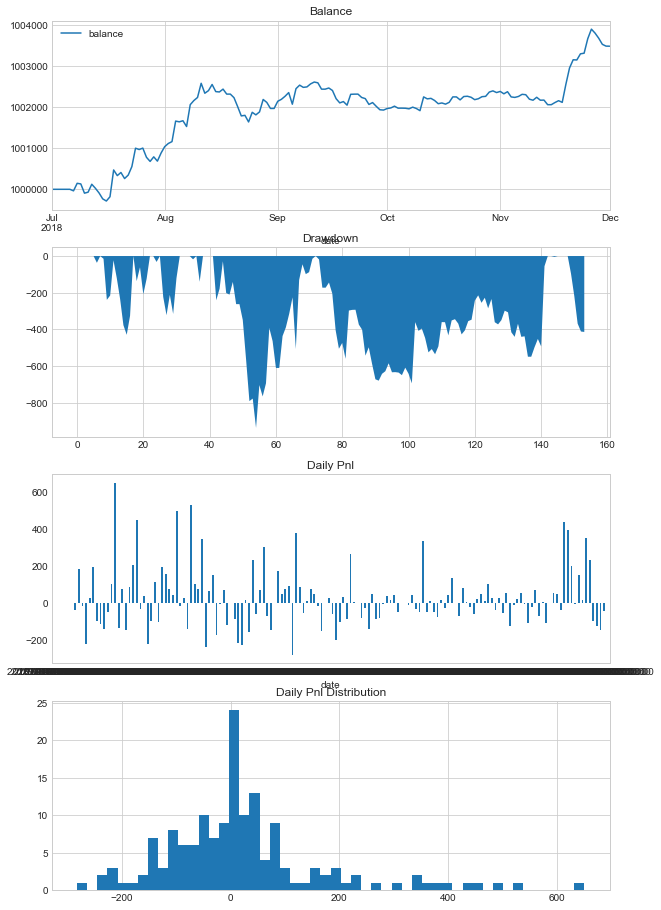

In [59]:
# 显示逐日回测结果
engine.showDailyResult()

In [60]:
import pandas as pd
tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
tradeDf = tradeReport.set_index('dt')
tradeDf

,direction,exchange,exchangeOrderID,fee,gatewayName,offset,orderID,orderTime,price,price_avg,rawData,status,symbol,tradeID,tradeTime,volume,vtOrderID,vtSymbol,vtTradeID
dt,,,,,,,,,,,,,,,,,,,
2018-07-07 16:00:00,多,,,0.0,,开仓,1,,6591.78,0.0,None,,,1,2018-07-07 16:00:00,1,1,BTCUSDT:binance,1
2018-07-10 17:21:00,空,,,0.0,,平仓,2,,6526.64,0.0,None,,,2,2018-07-10 17:21:00,1,2,BTCUSDT:binance,2
2018-07-10 20:00:00,空,,,0.0,,开仓,3,,6365.06,0.0,None,,,3,2018-07-10 20:00:00,1,3,BTCUSDT:binance,3
2018-07-14 02:22:00,多,,,0.0,,平仓,4,,6333.79,0.0,None,,,4,2018-07-14 02:22:00,1,4,BTCUSDT:binance,4
2018-07-14 15:00:00,空,,,0.0,,开仓,5,,6203.39,0.0,None,,,5,2018-07-14 15:00:00,1,5,BTCUSDT:binance,5
2018-07-16 17:21:00,多,,,0.0,,平仓,6,,6434.79,0.0,None,,,6,2018-07-16 17:21:00,1,6,BTCUSDT:binance,6
2018-07-17 02:00:00,多,,,0.0,,开仓,7,,6671.00,0.0,None,,,7,2018-07-17 02:00:00,1,7,BTCUSDT:binance,7
2018-07-19 04:11:00,空,,,0.0,,平仓,8,,7268.88,0.0,None,,,8,2018-07-19 04:11:00,1,8,BTCUSDT:binance,8
2018-07-19 07:00:00,多,,,0.0,,开仓,9,,7362.19,0.0,None,,,9,2018-07-19 07:00:00,1,9,BTCUSDT:binance,9


2018-12-16 21:34:11.114206	计算回测结果
2018-12-16 21:34:11.120195	------------------------------
2018-12-16 21:34:11.120195	第一笔交易：	2018-07-10 17:21:00
2018-12-16 21:34:11.120195	最后一笔交易：	2018-12-01 11:58:00
2018-12-16 21:34:11.120694	总交易次数：	57
2018-12-16 21:34:11.120694	总盈亏：	3,473.64
2018-12-16 21:34:11.120694	最大回撤: 	-912.97
2018-12-16 21:34:11.120694	平均每笔盈利：	60.94
2018-12-16 21:34:11.120694	平均每笔滑点：	0.0
2018-12-16 21:34:11.120694	平均每笔佣金：	6.18
2018-12-16 21:34:11.120694	胜率		49.12%
2018-12-16 21:34:11.120694	盈利交易平均值	256.55
2018-12-16 21:34:11.120694	亏损交易平均值	-127.92
2018-12-16 21:34:11.120694	盈亏比：	2.01


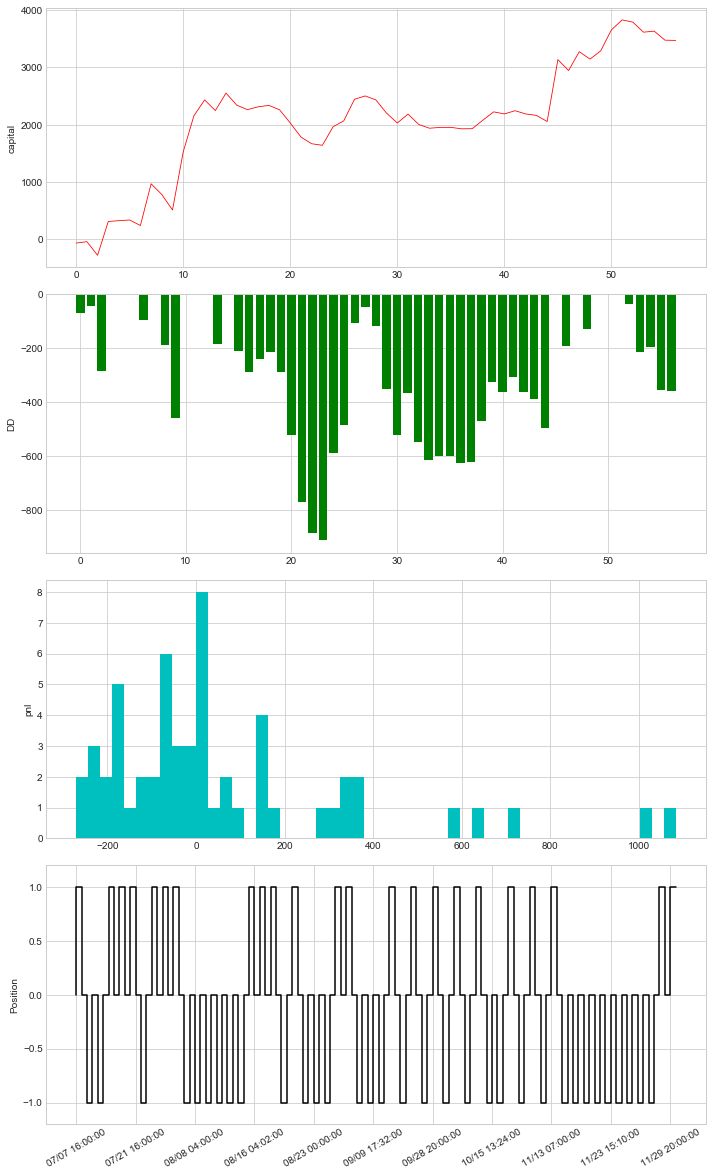

In [61]:
# 显示逐笔回测结果
engine.showBacktestingResult()

In [56]:
from vnpy.trader.app.ctaStrategy.ctaBacktesting  import OptimizationSetting
# 优化配置
setting = OptimizationSetting()                # 新建一个优化任务设置对象
setting.setOptimizeTarget('sharpeRatio')       # 设置优化排序的目标是夏普

setting.addParameter('VWAPPeriod', 30, 80, 10)

setting.addParameter('symbolList', ['BTCUSDT:binance']) 

import time
start = time.time()
# 执行单线程优化
resultList = engine.runOptimization(ReversalStrategy, setting)
# 执行多进程优化一般会改写成py文件然后用多线程运行，提高优化速度。
# resultList = engine.runParallelOptimization(Strategy, setting)
# print('耗时：%s' %(time.time()-start))

2018-12-16 21:28:57.036749	------------------------------
2018-12-16 21:28:57.036749	setting: {'VWAPPeriod': 30, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function ReversalStrategy.on60MinBar at 0x000001AA097F90D0>, <__main__.ReversalStrategy object at 0x000001AA0CE29780>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function ReversalStrategy.onBar at 0x000001AA07805E18>, <__main__.ReversalStrategy object at 0x000001AA0CE29780>)
2018-12-16 21:28:57.066694	开始回测
2018-12-16 21:28:57.067692	策略初始化
2018-12-16 21:28:57.069190	载入历史数据。数据范围:[20180623 04:00,20180701 12:00)
2018-12-16 21:28:57.522248	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-16 21:28:57.526240	载入完成，数据量：11295
2018-12-16 21:28:57.526740	策略初始化完成
2018-12-16 21:28:57.527241	策略启动完成
2018-12-16 21:28:57.527241	开始回放回测数据,回测范围:[20180701 12:00,20181201 12:00)
2018-12-16 21:28:57.549197	载入历史数据。数据范围:[201

2018-12-16 21:30:10.348293	------------------------------
2018-12-16 21:30:10.348792	setting: {'VWAPPeriod': 60, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function ReversalStrategy.on60MinBar at 0x000001AA0E7686A8>, <__main__.ReversalStrategy object at 0x000001AA0BFEDF98>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function ReversalStrategy.onBar at 0x000001AA0E768840>, <__main__.ReversalStrategy object at 0x000001AA0BFEDF98>)
2018-12-16 21:30:10.394209	开始回测
2018-12-16 21:30:10.394708	策略初始化
2018-12-16 21:30:10.396703	载入历史数据。数据范围:[20180623 04:00,20180701 12:00)
2018-12-16 21:30:10.840890	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-16 21:30:10.844371	载入完成，数据量：11295
2018-12-16 21:30:10.844870	策略初始化完成
2018-12-16 21:30:10.844870	策略启动完成
2018-12-16 21:30:10.845369	开始回放回测数据,回测范围:[20180701 12:00,20181201 12:00)
2018-12-16 21:30:10.866328	载入历史数据。数据范围:[201

2018-12-16 21:31:25.525102	------------------------------
2018-12-16 21:31:25.525600	优化结果：
2018-12-16 21:31:25.525600	参数：["{'VWAPPeriod': 70, 'symbolList': ['BTCUSDT:binance']}"]，目标：2.23221532985
2018-12-16 21:31:25.525600	参数：["{'VWAPPeriod': 50, 'symbolList': ['BTCUSDT:binance']}"]，目标：2.11421875135
2018-12-16 21:31:25.526106	参数：["{'VWAPPeriod': 60, 'symbolList': ['BTCUSDT:binance']}"]，目标：2.11079872404
2018-12-16 21:31:25.526106	参数：["{'VWAPPeriod': 40, 'symbolList': ['BTCUSDT:binance']}"]，目标：2.06988416417
2018-12-16 21:31:25.526106	参数：["{'VWAPPeriod': 80, 'symbolList': ['BTCUSDT:binance']}"]，目标：1.97757945493
2018-12-16 21:31:25.526106	参数：["{'VWAPPeriod': 30, 'symbolList': ['BTCUSDT:binance']}"]，目标：1.94646058929
